In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Dataset class
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx]["id"]) + ".png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            return image, label
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)



In [3]:
# Paths and data loading
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "images_train"
test_images_path = "images_test"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
# Datasets and DataLoaders
train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [5]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
# Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    scheduler.step()

Epoch 1/20, Loss: 0.6266, Accuracy: 0.67, Precision: 0.67, Recall: 0.67, F1-Score: 0.67
Epoch 2/20, Loss: 0.5541, Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-Score: 0.72
Epoch 3/20, Loss: 0.5394, Accuracy: 0.74, Precision: 0.74, Recall: 0.74, F1-Score: 0.74
Epoch 4/20, Loss: 0.5250, Accuracy: 0.74, Precision: 0.74, Recall: 0.74, F1-Score: 0.74
Epoch 5/20, Loss: 0.5172, Accuracy: 0.75, Precision: 0.75, Recall: 0.75, F1-Score: 0.75
Epoch 6/20, Loss: 0.4942, Accuracy: 0.76, Precision: 0.76, Recall: 0.76, F1-Score: 0.76
Epoch 7/20, Loss: 0.4657, Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.78
Epoch 8/20, Loss: 0.4733, Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.78
Epoch 9/20, Loss: 0.4609, Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.78
Epoch 10/20, Loss: 0.4611, Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.78
Epoch 11/20, Loss: 0.4535, Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.78
Epoch 12/20, Loss: 0.4516, Acc

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       719
           1       0.84      0.74      0.79       740

    accuracy                           0.80      1459
   macro avg       0.80      0.80      0.80      1459
weighted avg       0.80      0.80      0.80      1459

Accuracy: 0.7978067169294037
Precision: 0.802489321689343
Recall: 0.7986824794196143
F1-Score: 0.7973131113441648


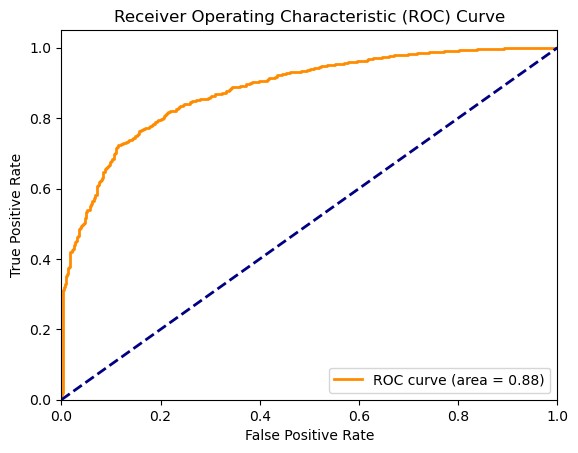

In [15]:
# Inference on Test Data
model.eval()
predictions = []
image_ids = []
probs = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})

# Merge with Ground Truth for Evaluation
solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")
y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# Plot AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Dataset class
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx]["id"]) + ".png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            return image, label
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)

# Paths and data loading
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "images_train"
test_images_path = "images_test"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets and DataLoaders
train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1024 * 7 * 7, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



In [9]:
# Training
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    scheduler.step()



Epoch 1/40, Loss: 0.6449, Accuracy: 0.68, Precision: 0.68, Recall: 0.68, F1-Score: 0.68
Epoch 2/40, Loss: 0.5557, Accuracy: 0.73, Precision: 0.73, Recall: 0.73, F1-Score: 0.73
Epoch 3/40, Loss: 0.5376, Accuracy: 0.74, Precision: 0.74, Recall: 0.74, F1-Score: 0.74
Epoch 4/40, Loss: 0.5210, Accuracy: 0.76, Precision: 0.76, Recall: 0.76, F1-Score: 0.76
Epoch 5/40, Loss: 0.4877, Accuracy: 0.77, Precision: 0.77, Recall: 0.77, F1-Score: 0.77
Epoch 6/40, Loss: 0.4458, Accuracy: 0.80, Precision: 0.81, Recall: 0.81, F1-Score: 0.80
Epoch 7/40, Loss: 0.4228, Accuracy: 0.81, Precision: 0.81, Recall: 0.81, F1-Score: 0.81
Epoch 8/40, Loss: 0.4130, Accuracy: 0.81, Precision: 0.82, Recall: 0.81, F1-Score: 0.81
Epoch 9/40, Loss: 0.4145, Accuracy: 0.82, Precision: 0.82, Recall: 0.82, F1-Score: 0.82
Epoch 10/40, Loss: 0.3911, Accuracy: 0.83, Precision: 0.83, Recall: 0.83, F1-Score: 0.83
Epoch 11/40, Loss: 0.3794, Accuracy: 0.84, Precision: 0.84, Recall: 0.84, F1-Score: 0.84
Epoch 12/40, Loss: 0.3666, Acc

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       719
           1       0.90      0.79      0.84       740

    accuracy                           0.85      1459
   macro avg       0.86      0.85      0.85      1459
weighted avg       0.86      0.85      0.85      1459

Accuracy: 0.8512679917751885
Precision: 0.8561666362488783
Recall: 0.852115362928993
F1-Score: 0.8509442072411428


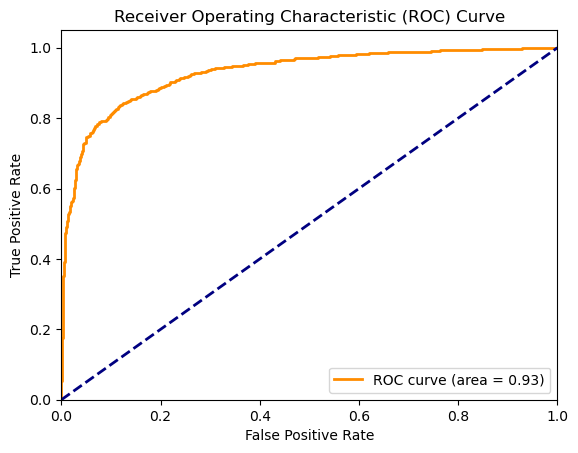

In [10]:
# Inference and Evaluation
model.eval()
predictions = []
image_ids = []
probs = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})
solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")
y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Enable GPU optimizations
torch.backends.cudnn.benchmark = True

# Dataset class
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.df.iloc[idx]['id']}.png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]['ground_truth']
            return image, label
        else:
            return image, self.df.iloc[idx]['id']

    def __len__(self):
        return len(self.df)


# Paths and data loading
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "images_train"
test_images_path = "images_test"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets and DataLoaders
train_dataset = SARImageDataset(train_df, train_images_path, transform=train_transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=test_transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)



In [18]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)


C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
# Training loop
num_epochs = 40
best_f1 = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    scheduler.step(train_loss)

    # Save the best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved with F1-Score:", best_f1)


Epoch 1/40, Loss: 0.7503, Accuracy: 0.61, Precision: 0.62, Recall: 0.61, F1-Score: 0.61
Model saved with F1-Score: 0.6135028243942147
Epoch 2/40, Loss: 0.6193, Accuracy: 0.68, Precision: 0.69, Recall: 0.68, F1-Score: 0.68
Model saved with F1-Score: 0.68393177924303
Epoch 3/40, Loss: 0.5635, Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-Score: 0.72
Model saved with F1-Score: 0.7202553499503015
Epoch 4/40, Loss: 0.5551, Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-Score: 0.72
Model saved with F1-Score: 0.7206576155220974
Epoch 5/40, Loss: 0.5395, Accuracy: 0.74, Precision: 0.74, Recall: 0.74, F1-Score: 0.74
Model saved with F1-Score: 0.7393098639314536
Epoch 6/40, Loss: 0.5212, Accuracy: 0.75, Precision: 0.75, Recall: 0.75, F1-Score: 0.75
Model saved with F1-Score: 0.7471032642792763
Epoch 7/40, Loss: 0.5104, Accuracy: 0.76, Precision: 0.76, Recall: 0.76, F1-Score: 0.76
Model saved with F1-Score: 0.7607925110153881
Epoch 8/40, Loss: 0.5039, Accuracy: 0.76, Precision: 0.76, Recal

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       719
           1       0.96      0.87      0.91       740

    accuracy                           0.92      1459
   macro avg       0.92      0.92      0.92      1459
weighted avg       0.92      0.92      0.92      1459

Accuracy: 0.9177518848526388
Precision: 0.9213532479920059
Recall: 0.9184452881253994
F1-Score: 0.9176512642986153


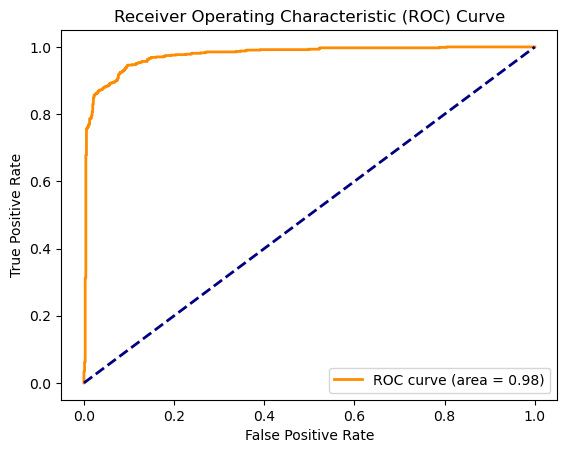

In [20]:
# Evaluation
model.eval()
predictions, image_ids, probs = [], [], []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})
solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")
y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
